In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import jax

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Couplings J1 and J2
J = [1, 0.2]
L = 8

In [4]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])
# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

In [5]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

In [6]:
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [7]:
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

In [10]:
import netket.nn as nknn
import flax.linen as nn
import jax.numpy as jnp

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

model = FFNN()

In [11]:
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)
vs = nk.vqs.MCState(sa, model, n_samples=1008)
opt = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.01)
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [12]:
vs

MCState(
  hilbert = Spin(s=1/2, total_sz=0.0, N=8),
  sampler = MetropolisSampler(rule = ExchangeRule(# of clusters: 28), n_chains = 16, n_sweeps = 8, reset_chains = False, machine_power = 2, dtype = <class 'float'>),
  n_samples = 1008,
  n_discard_per_chain = 100,
  sampler_state = MetropolisSamplerState(rng state=[ 301143319 4284432549]),
  n_parameters = 144)

In [13]:
vs.parameters['Dense_0']['bias']

Array([ 1.63342291e-02+0.00608696j,  4.92325308e-03+0.00185465j,
        5.92234418e-03+0.00032981j, -4.83454007e-03-0.00700322j,
        8.70033499e-04-0.00293282j, -3.26007342e-03-0.00471568j,
       -9.18079708e-04+0.00499488j,  1.07081042e-02+0.00640006j,
       -3.66114726e-04+0.00270781j,  4.99575223e-03+0.00850429j,
       -1.27228891e-03-0.0002415j ,  3.23989566e-03-0.00331018j,
        8.36982152e-06-0.00554132j,  6.25141016e-03+0.00492955j,
        1.47580379e-02+0.00149897j, -2.25203911e-02-0.01947328j],      dtype=complex128)

In [14]:
# Define a função de perda (loss function) para o treinamento
def loss(params, structure_factor):
    output = model.apply({'params': params}, structure_factor)
    return jnp.mean(output)

In [15]:
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

In [16]:
#Função para acessar o bias e o kernel após o treinamento
def get_model_params(trained_params):
    kernel = model.get_kernel(trained_params)
    bias = model.get_bias(trained_params)
    return kernel, bias

In [18]:
# Define uma lista para armazenar os parâmetros do modelo durante o treinamento
trained_params_list = []
parameters_list     = []
iii                 = []
# Função de callback para salvar os parâmetros durante o treinamento
def save_params(step, params, energy):
    print("############ it    ", 1 + len(iii))
    print("############ energy", energy.state.parameters)
    
    trained_params_list.append(params.copy())
    parameters_list.append(energy.state.parameters.copy())
    iii.append(1)
    return True

In [19]:
gs.run(out='test', n_iter=50, obs={'Structure Factor': structure_factor}, callback=save_params)

  4%|███▋                                                                                       | 2/50 [00:00<00:03, 15.65it/s, Energy=-9.94+0.00j ± 0.16 [σ²=24.31, R̂=1.0060]]

############ it     0
############ energy {'Dense_0': {'bias': Array([ 1.63342291e-02+0.00608696j,  4.92325308e-03+0.00185465j,
        5.92234418e-03+0.00032981j, -4.83454007e-03-0.00700322j,
        8.70033499e-04-0.00293282j, -3.26007342e-03-0.00471568j,
       -9.18079708e-04+0.00499488j,  1.07081042e-02+0.00640006j,
       -3.66114726e-04+0.00270781j,  4.99575223e-03+0.00850429j,
       -1.27228891e-03-0.0002415j ,  3.23989566e-03-0.00331018j,
        8.36982152e-06-0.00554132j,  6.25141016e-03+0.00492955j,
        1.47580379e-02+0.00149897j, -2.25203911e-02-0.01947328j],      dtype=complex128), 'kernel': Array([[-5.96503706e-03-6.62595292e-03j, -1.91763761e-03-2.26275790e-03j,
        -7.30452620e-03+1.14736495e-02j, -1.91367715e-03-5.33458703e-03j,
        -6.74518403e-03+4.05643780e-03j,  5.26208335e-03+2.78493555e-05j,
         4.56640597e-03-4.02539466e-03j, -2.05921847e-03-1.25776057e-02j,
         4.00738096e-04+7.37953641e-03j,  5.99819335e-03+1.45800500e-03j,
         1.9

 12%|██████████▊                                                                               | 6/50 [00:00<00:02, 16.66it/s, Energy=-11.74-0.00j ± 0.12 [σ²=15.52, R̂=1.0096]]

############ it     4
############ energy {'Dense_0': {'bias': Array([ 0.00839326+4.16782110e-03j,  0.00870044+2.65083782e-05j,
        0.00375172+9.68469985e-04j, -0.0006036 -2.16665546e-03j,
       -0.00402145-6.24737334e-03j, -0.00701983-6.89176273e-03j,
        0.00483094+5.69903162e-03j,  0.01190323+6.68745593e-03j,
       -0.01047945-3.34069234e-03j,  0.00246988+6.23961258e-03j,
        0.00051311+1.04226839e-02j,  0.0009118 -1.58953011e-03j,
        0.00133162-2.21967480e-03j,  0.00071474+4.10861024e-03j,
        0.01267767+5.14021954e-03j, -0.0232913 -1.91065170e-02j],      dtype=complex128), 'kernel': Array([[ 0.01964406+0.00623153j,  0.00865071+0.05144972j,
         0.00107605+0.07296037j, -0.0013898 -0.03439313j,
        -0.05032401+0.07708775j, -0.02012893-0.02649135j,
         0.01656512+0.04273993j,  0.05563149-0.00616292j,
         0.01186365+0.06384203j, -0.00321336+0.05441148j,
         0.05896278-0.03697196j, -0.03343611+0.01914247j,
         0.03525511-0.06321696j,  

 20%|█████████████████▏                                                                    | 10/50 [00:00<00:02, 16.48it/s, Energy=-12.472+0.000j ± 0.085 [σ²=7.289, R̂=1.0088]]

############ it     8
############ energy {'Dense_0': {'bias': Array([ 7.23591982e-03+0.00334126j,  8.57589366e-03-0.00056537j,
        3.98644682e-03+0.00084917j, -3.84234359e-05-0.00177798j,
       -4.81415718e-03-0.00698374j, -7.19796138e-03-0.00677118j,
        4.43390566e-03+0.00484418j,  1.18371608e-02+0.00753191j,
       -1.16569271e-02-0.00427736j,  1.92832688e-03+0.00564147j,
        1.93231434e-03+0.00976208j, -7.62034864e-04-0.0015794j ,
        2.09058601e-03-0.00163969j,  4.56325258e-04+0.00417948j,
        1.20141242e-02+0.004671j  , -2.02804432e-02-0.0183312j ],      dtype=complex128), 'kernel': Array([[ 0.02564742+9.51162226e-03j,  0.01619586+7.55053409e-02j,
         0.00615569+1.04829198e-01j, -0.00101715-5.01395012e-02j,
        -0.07369059+1.07090363e-01j, -0.03171721-3.64622397e-02j,
         0.02961831+6.65243850e-02j,  0.08686553-2.25276643e-04j,
         0.01697688+9.25860538e-02j, -0.00701976+7.69289938e-02j,
         0.0862333 -5.41154035e-02j, -0.04634193+3.8

 28%|████████████████████████                                                              | 14/50 [00:00<00:02, 16.17it/s, Energy=-12.785-0.001j ± 0.065 [σ²=4.279, R̂=1.0074]]

############ it     12
############ energy {'Dense_0': {'bias': Array([ 0.00658811+0.0026101j ,  0.00823349-0.0008535j ,
        0.00410713+0.0012562j ,  0.00010963-0.00201561j,
       -0.00479334-0.00709372j, -0.00740695-0.00705281j,
        0.00346934+0.00366441j,  0.01184039+0.00701561j,
       -0.01209225-0.00507787j,  0.0017123 +0.00523864j,
        0.00201581+0.0094588j , -0.00135261-0.00061418j,
        0.00234769-0.00110862j,  0.00010745+0.00438414j,
        0.01175212+0.00451628j, -0.01912174-0.01689688j],      dtype=complex128), 'kernel': Array([[ 0.02779186+0.01063791j,  0.02020941+0.09398573j,
         0.00944937+0.12856072j, -0.00067327-0.06232101j,
        -0.08443883+0.12807838j, -0.03838639-0.0431746j ,
         0.0363172 +0.08466994j,  0.10238825+0.00383836j,
         0.02083726+0.113951j  , -0.00870115+0.09316731j,
         0.10069495-0.06464361j, -0.05254464+0.0567782j ,
         0.0511058 -0.1089775j ,  0.01473927+0.07599863j,
        -0.02572685+0.04883679j,  0.169

 36%|██████████████████████████████▉                                                       | 18/50 [00:01<00:02, 15.92it/s, Energy=-13.215-0.002j ± 0.045 [σ²=2.085, R̂=1.0092]]

############ it     16
############ energy {'Dense_0': {'bias': Array([ 0.00650263+0.0016717j ,  0.00806622-0.0011171j ,
        0.00425741+0.00126445j,  0.00027311-0.00226302j,
       -0.00479585-0.0071494j , -0.00760169-0.00704397j,
        0.00262503+0.00285296j,  0.01202757+0.00743761j,
       -0.0124471 -0.00585453j,  0.00168677+0.00480355j,
        0.00209908+0.0086456j , -0.00187964+0.00027885j,
        0.00248398-0.00045024j, -0.00040622+0.00435945j,
        0.0115612 +0.00448738j, -0.01827225-0.0156512j ],      dtype=complex128), 'kernel': Array([[ 0.02864102+1.09900928e-02j,  0.02242132+1.08909429e-01j,
         0.01135942+1.47776058e-01j, -0.00039425-7.27349607e-02j,
        -0.08920565+1.43970276e-01j, -0.04260841-4.82064827e-02j,
         0.03985831+9.90426089e-02j,  0.1116294 +5.72312103e-03j,
         0.02422279+1.31413046e-01j, -0.00943776+1.06109069e-01j,
         0.10964716-7.11506197e-02j, -0.05554462+7.36431727e-02j,
         0.05399529-1.23993844e-01j,  0.01577869+

 44%|█████████████████████████████████████▊                                                | 22/50 [00:01<00:01, 15.39it/s, Energy=-13.323+0.005j ± 0.029 [σ²=0.853, R̂=1.0174]]

############ it     20
############ energy {'Dense_0': {'bias': Array([ 0.00591991+0.00159598j,  0.0076567 -0.00196084j,
        0.00477879+0.00127214j,  0.00046584-0.0019615j ,
       -0.00510362-0.00684099j, -0.00784372-0.00699101j,
        0.00185957+0.00243247j,  0.01098241+0.00693118j,
       -0.01258624-0.00615161j,  0.0014293 +0.00408521j,
        0.00206466+0.00895103j, -0.00180336+0.00097044j,
        0.00248052-0.00021636j, -0.00046054+0.00445111j,
        0.01116715+0.00399156j, -0.01707837-0.01491923j],      dtype=complex128), 'kernel': Array([[ 0.02827112+0.01059492j,  0.02316624+0.12103616j,
         0.01278648+0.16318221j,  0.00032371-0.08144956j,
        -0.09086763+0.15700181j, -0.0449392 -0.05208007j,
         0.04168579+0.11068246j,  0.11616139+0.00751676j,
         0.02655308+0.1457769j , -0.0100368 +0.11661236j,
         0.11428721-0.07620903j, -0.05699166+0.08780059j,
         0.05547467-0.13607021j,  0.01583905+0.10179432j,
        -0.03031556+0.06465176j,  0.193

 52%|████████████████████████████████████████████▋                                         | 26/50 [00:01<00:01, 15.28it/s, Energy=-13.367+0.003j ± 0.023 [σ²=0.511, R̂=1.0188]]

############ it     24
############ energy {'Dense_0': {'bias': Array([ 0.0056387 +1.15092021e-03j,  0.00733253-2.04913898e-03j,
        0.00501898+1.59984780e-03j,  0.00087399-2.29362965e-03j,
       -0.00519889-6.71272859e-03j, -0.00801018-7.14678357e-03j,
        0.00147073+1.99576201e-03j,  0.01011002+6.63823663e-03j,
       -0.01227318-6.32450913e-03j,  0.00115164+4.03030673e-03j,
        0.00154236+8.13249076e-03j, -0.00173256+1.03984294e-03j,
        0.00244466+4.63151702e-05j, -0.00067717+4.60876066e-03j,
        0.01069657+3.90284457e-03j, -0.01575947-1.39196192e-02j],      dtype=complex128), 'kernel': Array([[ 0.02691478+0.01022317j,  0.02357703+0.13071211j,
         0.01395155+0.17475939j,  0.00074737-0.08865716j,
        -0.09126899+0.16711417j, -0.04634773-0.05518909j,
         0.04252885+0.1193213j ,  0.1166725 +0.0094995j ,
         0.02802347+0.15619261j, -0.01023101+0.12514996j,
         0.11609912-0.08040959j, -0.05794583+0.09819725j,
         0.05618319-0.14498147j, 

 60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:01<00:01, 15.27it/s, Energy=-13.333-0.001j ± 0.019 [σ²=0.365, R̂=1.0311]]

############ it     27
############ energy {'Dense_0': {'bias': Array([ 0.00569568+0.00069552j,  0.00724352-0.00212043j,
        0.00530945+0.00151456j,  0.00105617-0.00267527j,
       -0.00504716-0.00626512j, -0.00833704-0.0071654j ,
        0.00166267+0.00167024j,  0.00974912+0.00683361j,
       -0.01195936-0.00690155j,  0.00115455+0.00377919j,
        0.00067033+0.00727953j, -0.00223994+0.00139457j,
        0.00221701+0.00040744j, -0.00067439+0.00461226j,
        0.01027438+0.00403402j, -0.01494739-0.01301268j],      dtype=complex128), 'kernel': Array([[ 0.02603386+0.00965295j,  0.02341608+0.13631112j,
         0.01457139+0.18160751j,  0.00132046-0.09301415j,
        -0.09124508+0.1731362j , -0.04696669-0.05689345j,
         0.04291475+0.12438865j,  0.11661731+0.01056409j,
         0.02874251+0.1626011j , -0.01042627+0.13011357j,
         0.11677968-0.08314973j, -0.05839406+0.10445067j,
         0.05640132-0.15031007j,  0.01532866+0.11599542j,
        -0.03226459+0.07404829j,  0.202

 68%|██████████████████████████████████████████████████████████▍                           | 34/50 [00:02<00:01, 15.24it/s, Energy=-13.365-0.004j ± 0.014 [σ²=0.212, R̂=1.0218]]

############ it     31
############ energy {'Dense_0': {'bias': Array([ 0.00548531+0.00048951j,  0.00709271-0.00253462j,
        0.00576099+0.00169956j,  0.00109696-0.0026354j ,
       -0.00513035-0.00616082j, -0.00838944-0.00724681j,
        0.00127144+0.00131455j,  0.00886334+0.00623737j,
       -0.01170657-0.00702596j,  0.0009859 +0.00345875j,
        0.00088681+0.00736361j, -0.00229516+0.00180001j,
        0.00210387+0.00043713j, -0.00040131+0.0046738j ,
        0.00990053+0.00372541j, -0.01410019-0.01242022j],      dtype=complex128), 'kernel': Array([[ 0.02439426+0.00900019j,  0.02300975+0.14227677j,
         0.01509084+0.18854633j,  0.00158358-0.09796412j,
        -0.09063591+0.17949037j, -0.04743546-0.05876386j,
         0.0430209 +0.12946674j,  0.1155751 +0.01110789j,
         0.02950304+0.16913497j, -0.01054956+0.13551606j,
         0.11757889-0.08531571j, -0.05874511+0.11079534j,
         0.05635089-0.15558646j,  0.01502983+0.12172144j,
        -0.03296968+0.07785475j,  0.205

 76%|█████████████████████████████████████████████████████████████████▎                    | 38/50 [00:02<00:00, 15.12it/s, Energy=-13.394+0.001j ± 0.011 [σ²=0.113, R̂=1.0107]]

############ it     35
############ energy {'Dense_0': {'bias': Array([ 0.00512885+0.00016735j,  0.00695823-0.00273882j,
        0.00556289+0.00184202j,  0.00178642-0.00287429j,
       -0.0054702 -0.00582499j, -0.00820817-0.00712242j,
        0.00084199+0.00135877j,  0.00852456+0.00611229j,
       -0.0114148 -0.00720919j,  0.00095765+0.00302102j,
        0.00127051+0.00683409j, -0.00219638+0.00231561j,
        0.00220741+0.00082847j, -0.00064049+0.0049301j ,
        0.00973832+0.00355309j, -0.01365853-0.01160531j],      dtype=complex128), 'kernel': Array([[ 0.0227371 +0.00853365j,  0.02262899+0.14659275j,
         0.01549196+0.19372951j,  0.00184986-0.10180145j,
        -0.08984142+0.1841762j , -0.04749553-0.06012789j,
         0.04304419+0.13339204j,  0.11507668+0.0116348j ,
         0.03008827+0.17422745j, -0.01065354+0.13943107j,
         0.11755928-0.08756932j, -0.05876292+0.11578293j,
         0.05604076-0.15957597j,  0.01462444+0.1262927j ,
        -0.03352194+0.0805752j ,  0.206

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:02<00:00, 15.25it/s, Energy=-13.3950+0.0002j ± 0.0077 [σ²=0.0595, R̂=1.0214]]

############ it     39
############ energy {'Dense_0': {'bias': Array([ 0.00499721-8.43115024e-05j,  0.00684435-3.28767599e-03j,
        0.00594759+2.07391413e-03j,  0.00195176-2.81260612e-03j,
       -0.00554331-5.72305899e-03j, -0.00824435-7.14354570e-03j,
        0.00051952+1.12799671e-03j,  0.00789817+5.62944211e-03j,
       -0.01119011-7.21615350e-03j,  0.00086404+2.61593496e-03j,
        0.00128888+6.88509744e-03j, -0.0020396 +2.60977290e-03j,
        0.00207047+8.85832813e-04j, -0.00058307+4.76354399e-03j,
        0.00938527+3.15647689e-03j, -0.01296912-1.11041139e-02j],      dtype=complex128), 'kernel': Array([[ 0.02105213+0.00801206j,  0.02209554+0.15007179j,
         0.01570238+0.19767301j,  0.00221307-0.10499967j,
        -0.08879824+0.18755893j, -0.04737386-0.06133296j,
         0.0431504 +0.13656434j,  0.11380347+0.01133147j,
         0.03040386+0.1782301j , -0.0108173 +0.14269385j,
         0.1178044 -0.0884901j , -0.05868455+0.11943035j,
         0.05582253-0.16262623j, 

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:02<00:00, 15.16it/s, Energy=-13.4110-0.0006j ± 0.0056 [σ²=0.0317, R̂=1.0207]]

############ it     43
############ energy {'Dense_0': {'bias': Array([ 4.69179404e-03-0.00036557j,  6.83543098e-03-0.00379954j,
        6.29041682e-03+0.00223609j,  1.77992566e-03-0.00267994j,
       -5.55465294e-03-0.00571245j, -8.37304150e-03-0.00713111j,
       -6.57151531e-05+0.00068242j,  7.75649006e-03+0.00543604j,
       -1.10903321e-02-0.00697884j,  8.82305558e-04+0.00243592j,
        1.24669214e-03+0.00726307j, -2.10488199e-03+0.00281354j,
        1.92923270e-03+0.00081861j, -5.79198521e-04+0.00448484j,
        9.22781818e-03+0.00282101j, -1.24453705e-02-0.01100988j],      dtype=complex128), 'kernel': Array([[ 0.01994077+0.00755255j,  0.02142007+0.15252592j,
         0.01561091+0.20043959j,  0.00216567-0.10760834j,
        -0.08760165+0.18936439j, -0.04728337-0.06204415j,
         0.04281012+0.13917284j,  0.11324574+0.01186736j,
         0.03084   +0.18200201j, -0.01096975+0.1451163j ,
         0.11853435-0.08866256j, -0.05876811+0.12273311j,
         0.05571784-0.16520504j, 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.81it/s, Energy=-13.3985-0.0019j ± 0.0050 [σ²=0.0252, R̂=1.0201]]


############ it     47
############ energy {'Dense_0': {'bias': Array([ 0.00450826-0.00056366j,  0.00658613-0.00424667j,
        0.00652243+0.00254385j,  0.00191406-0.00279051j,
       -0.0057693 -0.00553469j, -0.008326  -0.00715031j,
       -0.00036758+0.00041625j,  0.00707267+0.00498117j,
       -0.0106399 -0.00687433j,  0.00068233+0.00208854j,
        0.00168798+0.0075238j , -0.00185685+0.00317456j,
        0.00176569+0.00070714j, -0.00038263+0.00453927j,
        0.00884211+0.00247906j, -0.01200452-0.01060428j],      dtype=complex128), 'kernel': Array([[ 0.01852122+0.00734453j,  0.02097336+0.15456581j,
         0.01552459+0.20249015j,  0.00209313-0.10977397j,
        -0.08655189+0.19119683j, -0.04704807-0.06264598j,
         0.04242066+0.14077477j,  0.11286159+0.01184122j,
         0.03133629+0.18461222j, -0.01097473+0.1471933j ,
         0.11887645-0.0892525j , -0.05859624+0.12497678j,
         0.05531033-0.1669j    ,  0.01239117+0.13476612j,
        -0.03471851+0.08592287j,  0.209

(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.013363122940063477
   	Params: 0.00046896934509277344,)

In [30]:
vs.parameters['Dense_0']['bias']

Array([ 0.00447867-0.00053987j,  0.00653414-0.00444222j,
        0.00667924+0.00242108j,  0.00209928-0.00275824j,
       -0.00572012-0.00533498j, -0.00840744-0.00718051j,
       -0.00043604+0.00059729j,  0.00689146+0.00482145j,
       -0.01050243-0.00679452j,  0.00065652+0.00208008j,
        0.00130397+0.00721265j, -0.00199497+0.0031313j ,
        0.0017182 +0.00072748j, -0.00050275+0.00456185j,
        0.00858157+0.00234764j, -0.01155756-0.01030959j],      dtype=complex128)

In [31]:
parameters_list[-1]['Dense_0']['bias']

Array([ 0.00446236-0.00058741j,  0.00654253-0.00455587j,
        0.0066006 +0.00255153j,  0.00206146-0.00272273j,
       -0.00572321-0.00542341j, -0.00831653-0.00715664j,
       -0.00044289+0.00049623j,  0.00689526+0.00474343j,
       -0.01046741-0.00671572j,  0.00066198+0.00192525j,
        0.00169533+0.0075996j , -0.00180471+0.00330279j,
        0.00175179+0.00064923j, -0.00044998+0.00455278j,
        0.00863941+0.00224708j, -0.01178485-0.0104497j ],      dtype=complex128)

In [32]:
list(vs.parameters['Dense_0']['kernel'])[0]

Array([ 0.01767596+0.00692782j,  0.02050384+0.15548093j,
        0.01547282+0.20364398j,  0.00212465-0.11095323j,
       -0.08586581+0.19174254j, -0.04689297-0.06292561j,
        0.04228066+0.14170356j,  0.11233194+0.01185746j,
        0.031606  +0.18611584j, -0.01108384+0.14812611j,
        0.11897294-0.08952531j, -0.0584863 +0.12619002j,
        0.0550986 -0.16791901j,  0.0121022 +0.13594668j,
       -0.0349935 +0.08653816j,  0.20975425-0.03795153j],      dtype=complex128)

In [33]:
list(parameters_list[-1]['Dense_0']['kernel'])[0]

Array([ 0.01797997+0.00712128j,  0.02066074+0.15522418j,
        0.01548673+0.20327514j,  0.00210586-0.11056377j,
       -0.08606761+0.1916505j , -0.04697248-0.06286032j,
        0.04227179+0.14139814j,  0.11242097+0.01188391j,
        0.03150562+0.18553711j, -0.01101062+0.14783092j,
        0.11895233-0.08945563j, -0.05854881+0.12571016j,
        0.05524548-0.16753765j,  0.01221398+0.1355874j ,
       -0.03486015+0.08635458j,  0.20961863-0.03799804j],      dtype=complex128)

In [34]:
# Load the data from the .log file
import json

data=json.load(open("test.log"))

iters = data['Energy']['iters']
energy=data['Energy']['Mean']['real']
sf=data['Structure Factor']['Mean']['real']

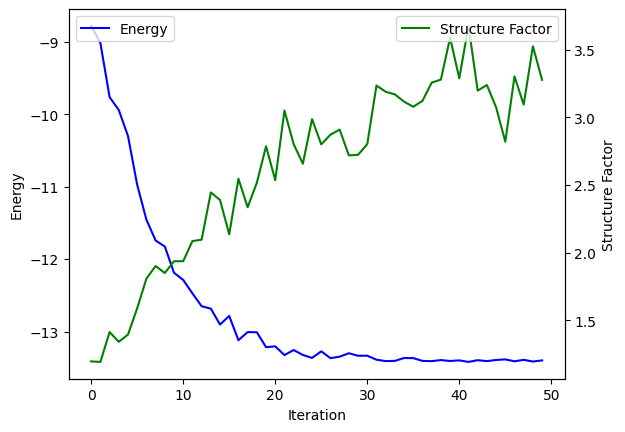

In [35]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [36]:
print(r"Structure factor = {0:.3f}({1:.3f})".format(np.mean(sf[-50:]),
                                              np.std(np.array(sf[-50:]))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Structure factor = 2.625(0.094)
Energy = -12.702(0.169)


In [37]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
structure_factor_gs = (ket_gs.T.conj()@structure_factor.to_linear_operator()@ket_gs).real[0,0]

In [38]:
print("Exact Ground-state Structure Factor: {0:.3f}".format(structure_factor_gs))
print("Exact ground state energy = {0:.3f}".format(E_gs[0]))

Exact Ground-state Structure Factor: 3.284
Exact ground state energy = -13.403
